In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import os

In [4]:
from sys import platform
print(platform)
if platform == "linux" or platform == "linux2":  # linux
    volume = '/media/julian/Volume/'
elif platform == "win32": # Windows.
    volume = 'G:/'

linux


In [10]:
p = os.path.join(volume, 'data/ECG/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/generated/1000/normalized-labels/train/00006_hr.h5')
full_data = None
with h5.File(p, 'r') as f:
    full_data = np.copy(f['data'])
data=full_data
print(data.shape)

(10000, 12)


In [ ]:
full_data = None
with h5.File('/media/julian/Volume/data/ECG/ptb-diagnostic-ecg-database-1.0.0/generated/normalized/test/patient007-s0078lre.h5', 'r') as f:
    full_data = np.copy(f['data'])
data=full_data
print(data.shape)

## Random visualization

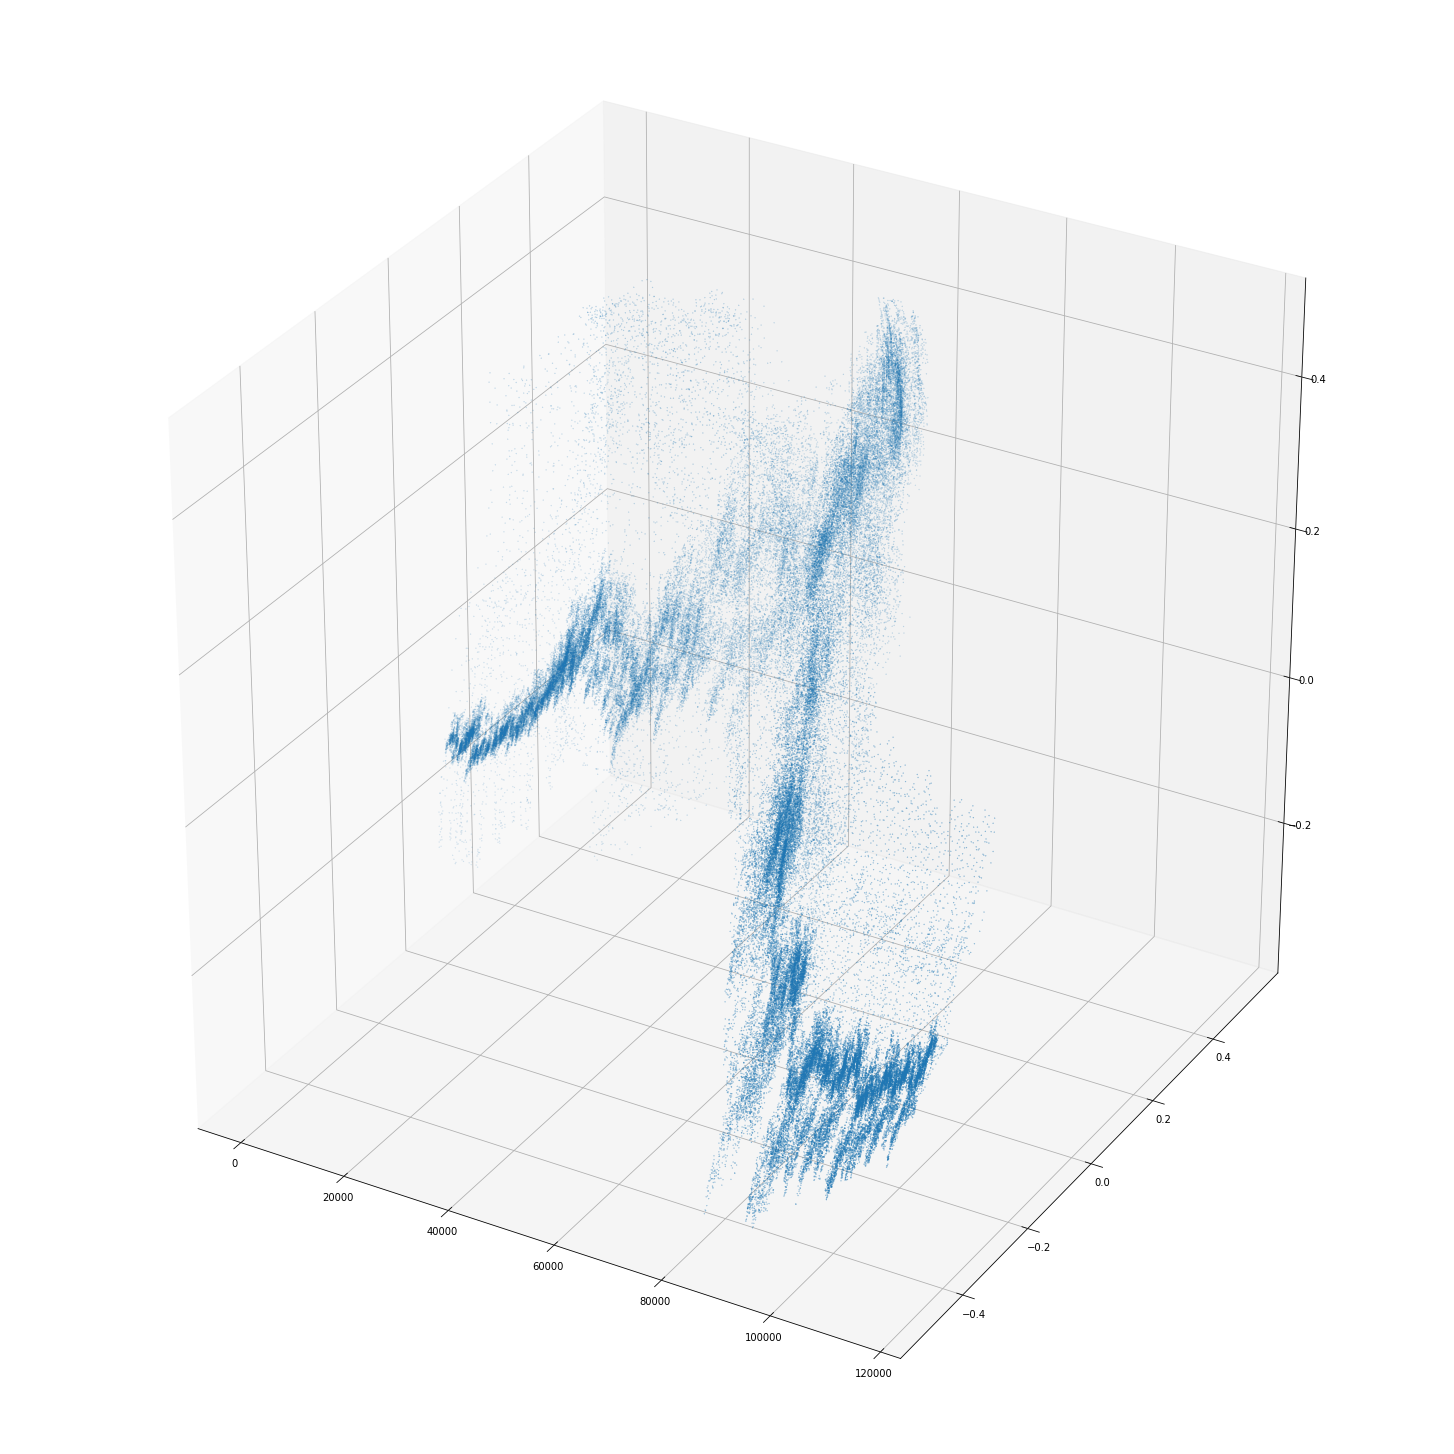

In [11]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random
data = full_data - np.mean(data, axis=0)

fig = pyplot.figure(figsize=(20, 20))
ax = Axes3D(fig)

ax.scatter(np.arange(len(data)), data[:, 0], data[:, 1], s = 0.05)
pyplot.show()

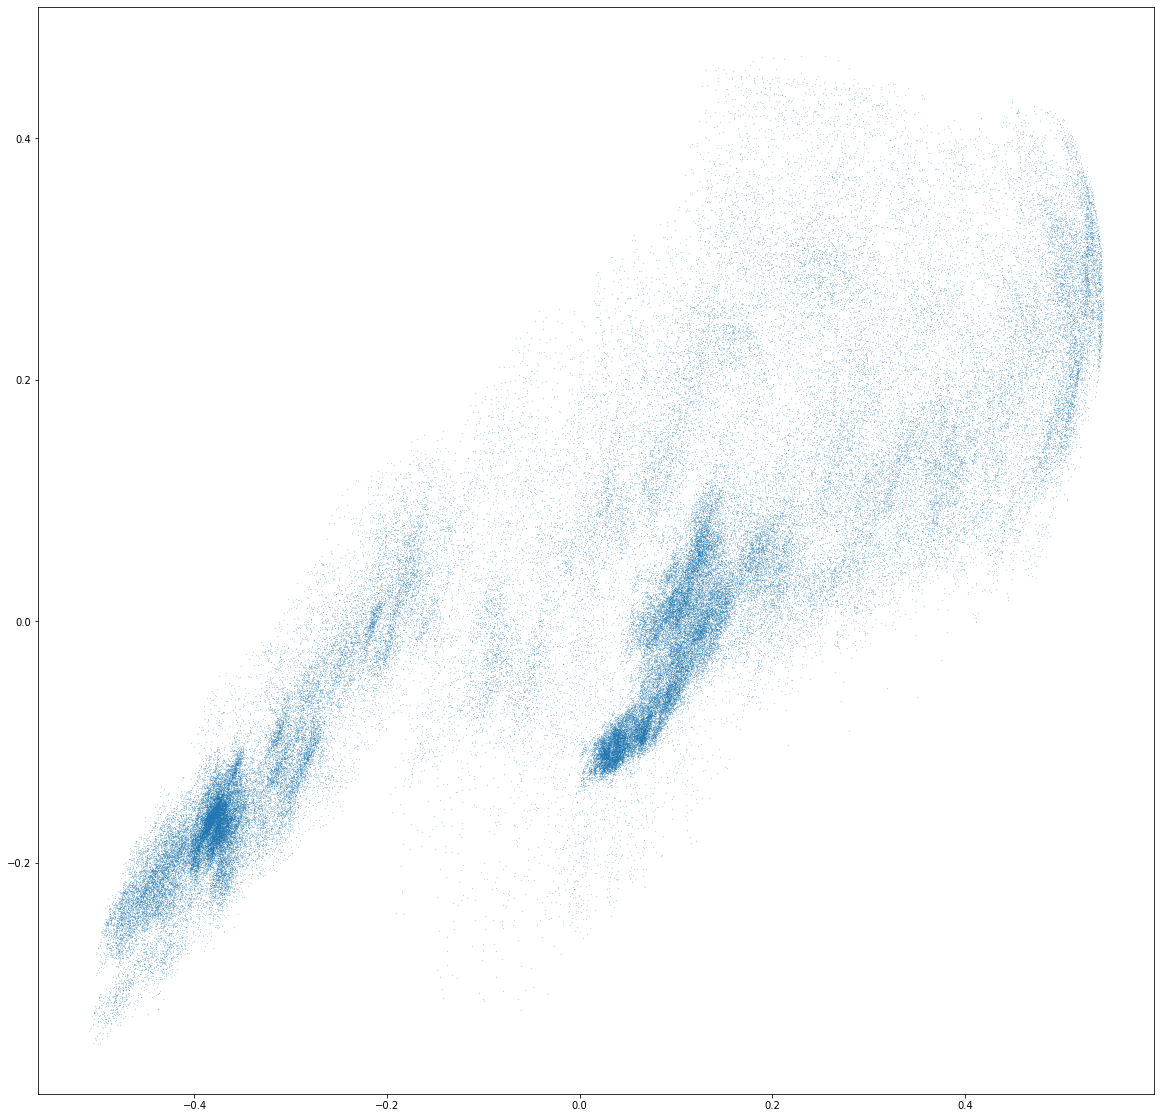

In [12]:
plt.figure(figsize=(20, 20))
plt.scatter(data[:, 0], data[:, 1], s=0.01)
plt.show()

[0.23730181 0.24108492 0.23891691 ... 0.72240054 0.71445627 0.71210611]
0.5482342734232651


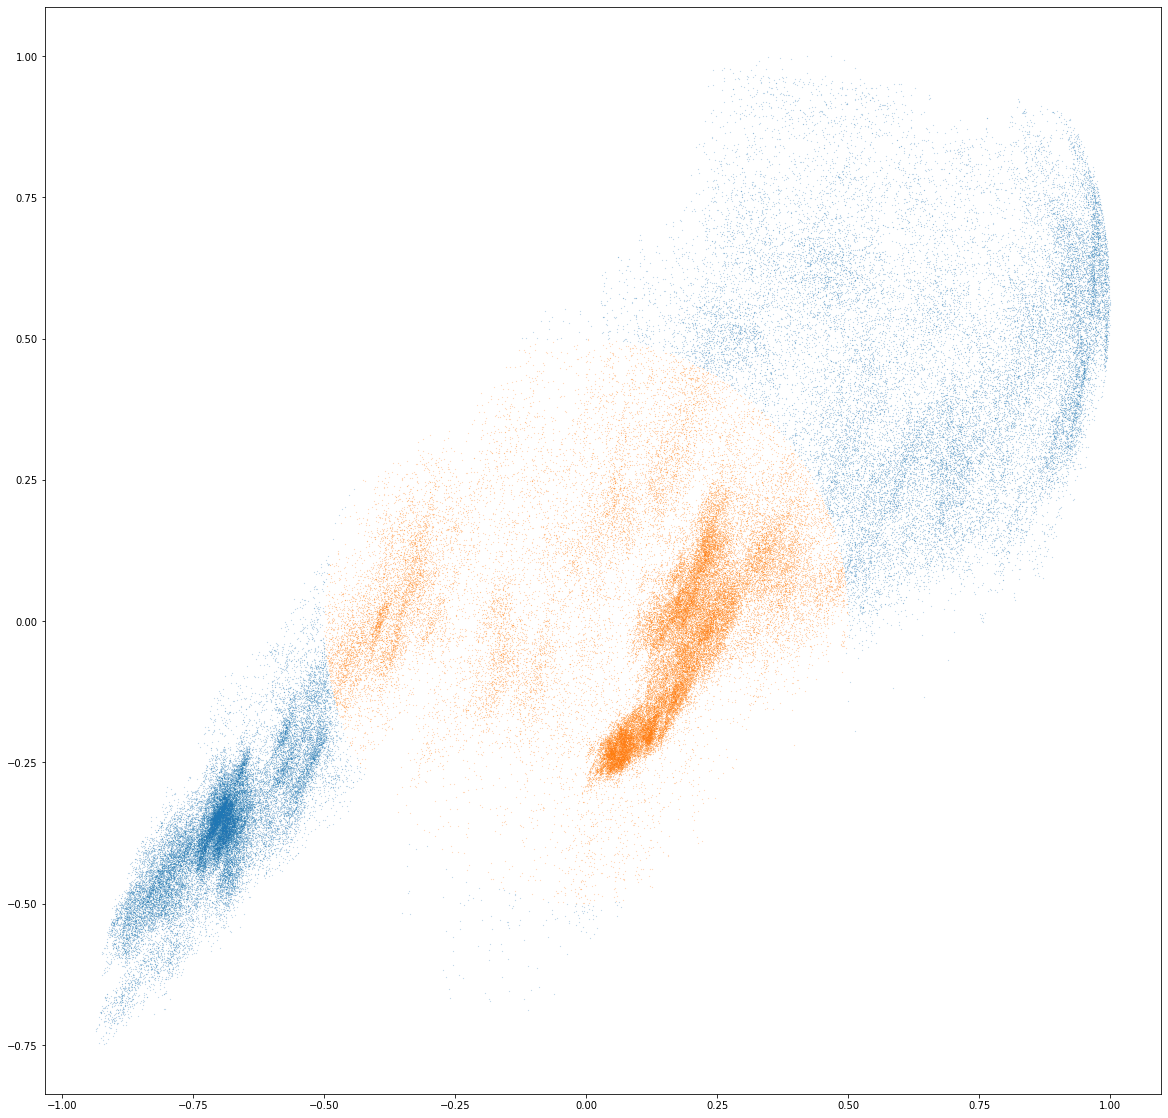

In [13]:
data = (data-np.mean(data, axis=0))/(np.max(data, axis=0) - np.mean(data, axis=0))
dists = np.sqrt(np.square(data[:,0])+np.square(data[:,1]))
print(dists)
medi = np.median(dists, axis=0)
print(medi)
mean = np.mean(dists, axis=0)
tresh = 0.5
x1 = data[:, 0]
x2 = data[:, 1]
plt.figure(figsize=(20, 20))
plt.scatter(x1[dists>tresh], x2[dists>tresh], s=0.01)
plt.scatter(x1[dists<=tresh], x2[dists<=tresh], s=0.01)
plt.show()

In [6]:
np.min(data, axis=0)

array([-1.06313741, -0.60005059])

In [7]:
plt.scatter(data[indices[:, 0], 0], data[indices[:, 0], 1])
plt.scatter(data[indices[:, 1], 0], data[indices[:, 1], 1])
plt.show()

NameError: name 'indices' is not defined

## Calculating distance matrix between points

In [11]:
from scipy.spatial import distance as d
data = full_data[0:10000, :]
distv = d.pdist(data)
distm = d.squareform(distv)
print(data.shape)

(10000, 12)


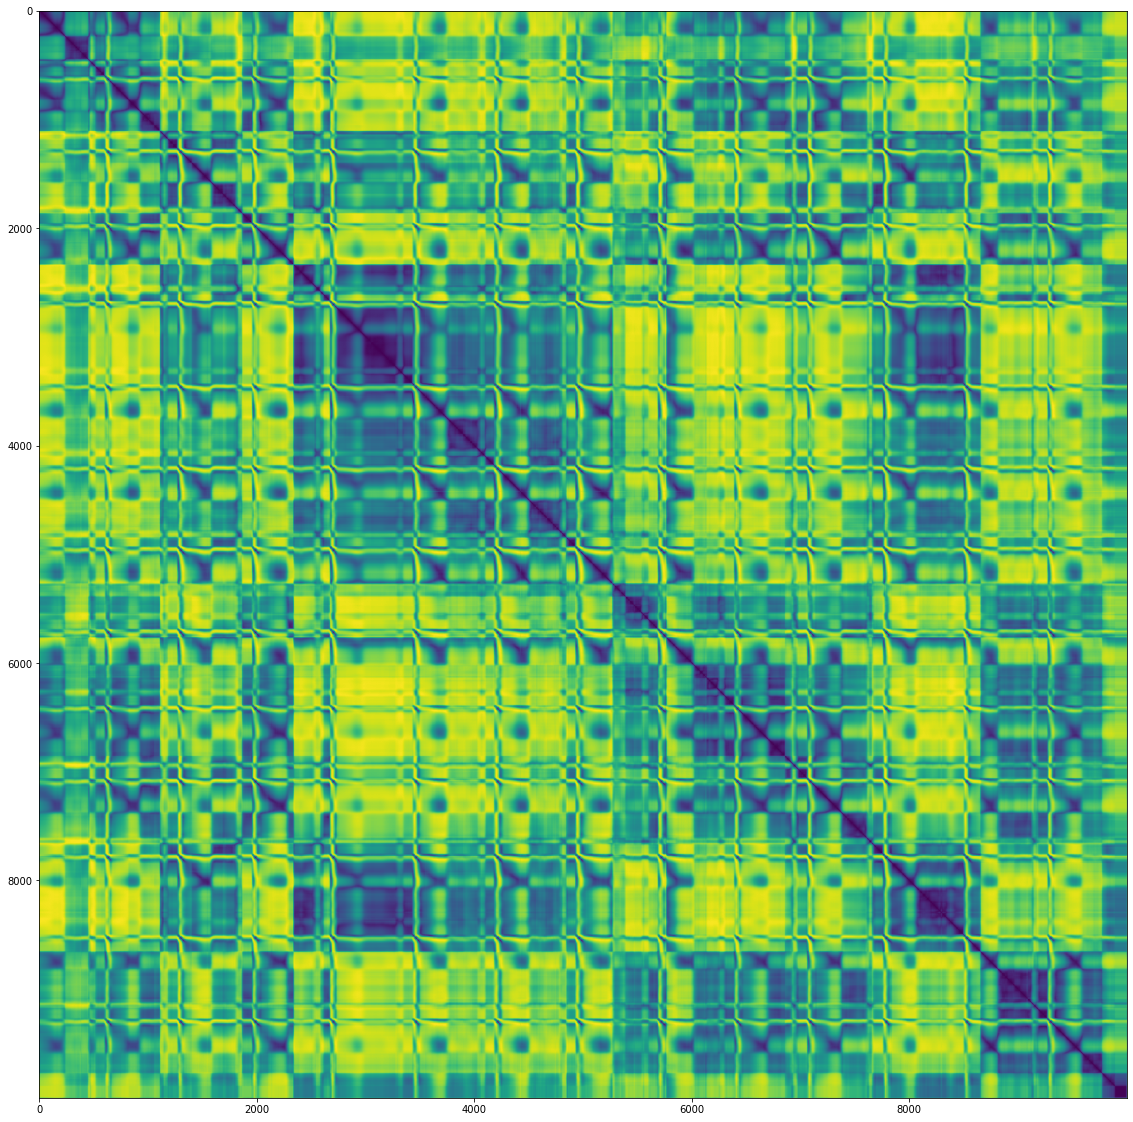

In [12]:
plt.figure(figsize=(20,20))
plt.imshow(distm)

## Summing columns of distance matrix
* Sum data in each column up
* Calculate mean and variance
* Divide data into bins where points are more than {0, 1, 2, ...} variances away from mean.

In [51]:
sums = np.sum(distm, axis=1)/len(distm)
sums_inv = np.exp(-sums)
m = np.mean(sums)
s = np.std(sums)
print('mean', m, 'standard deviation', s)
devs = []
for i in range(1, 100):
    devs += [np.argwhere((np.abs(sums-m) >= (i-1)*s) & (np.abs(sums-m)<i*s))]
    if len(devs[-1]) == 0:
        devs.pop()
        break
print('elements in bins:', *map(len, devs))    

mean 0.35489139553209464 standard deviation 0.18610522752559824
elements in bins: 9310 230 80 129 245 6


## Plot data (mean over all channels) with colors depending on bin

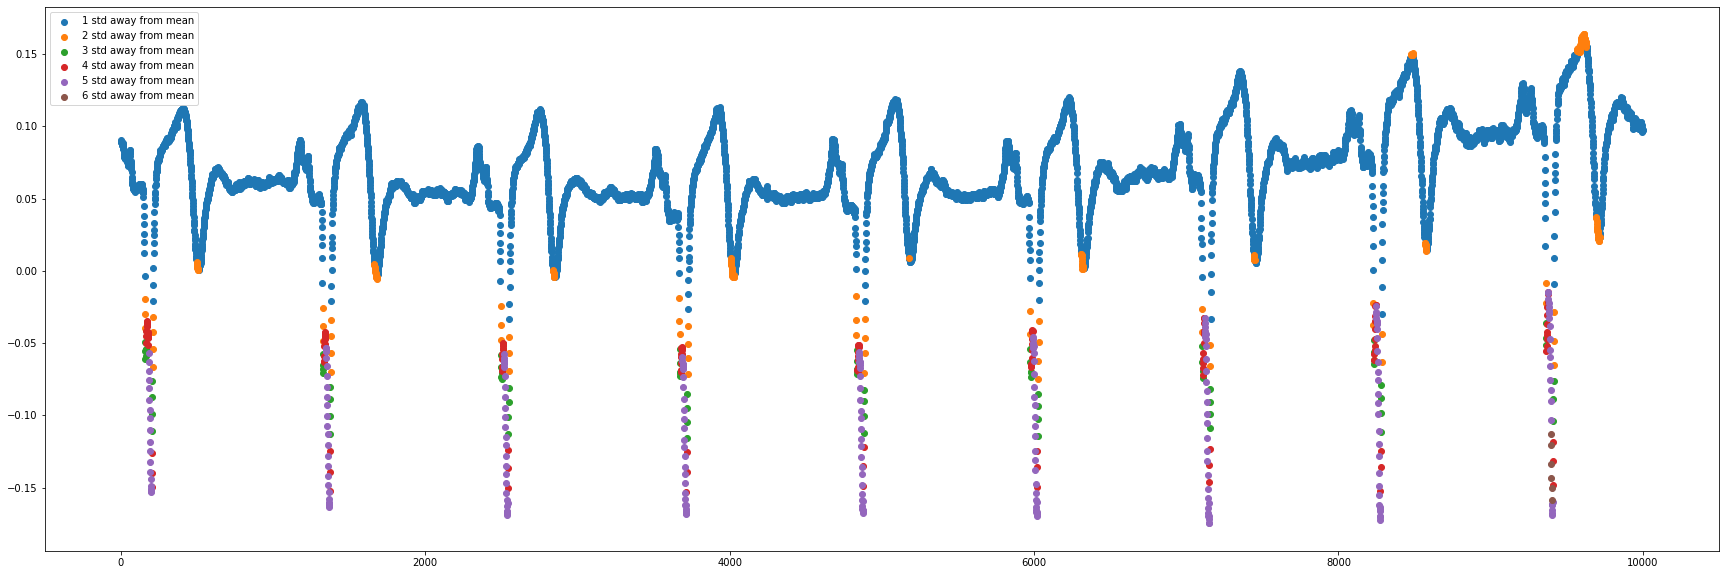

In [53]:
plt.figure(figsize=(30, 10))
for i,d in enumerate(devs):
    plt.scatter(np.arange(len(sums))[d], np.mean(data, axis=1)[d], label=str(i+1)+' std away from mean')
#plt.plot(sums_inv, label='inverted sums (exp(-sums))')
plt.legend()
plt.show()

In [54]:
from scipy.spatial import distance as d
data = full_data[0:10000, :]
distv = d.pdist(data)
distm = d.squareform(distv)
print(data.shape)

(10000, 12)


In [55]:
epsilon = np.var(distm)
neighbours = []
for i in range(distm.shape[1]):
    column = distm[:, i]
    neighbours += [np.argwhere(column<=epsilon)]
neighbour_counts = np.array(list(map(len,neighbours)))

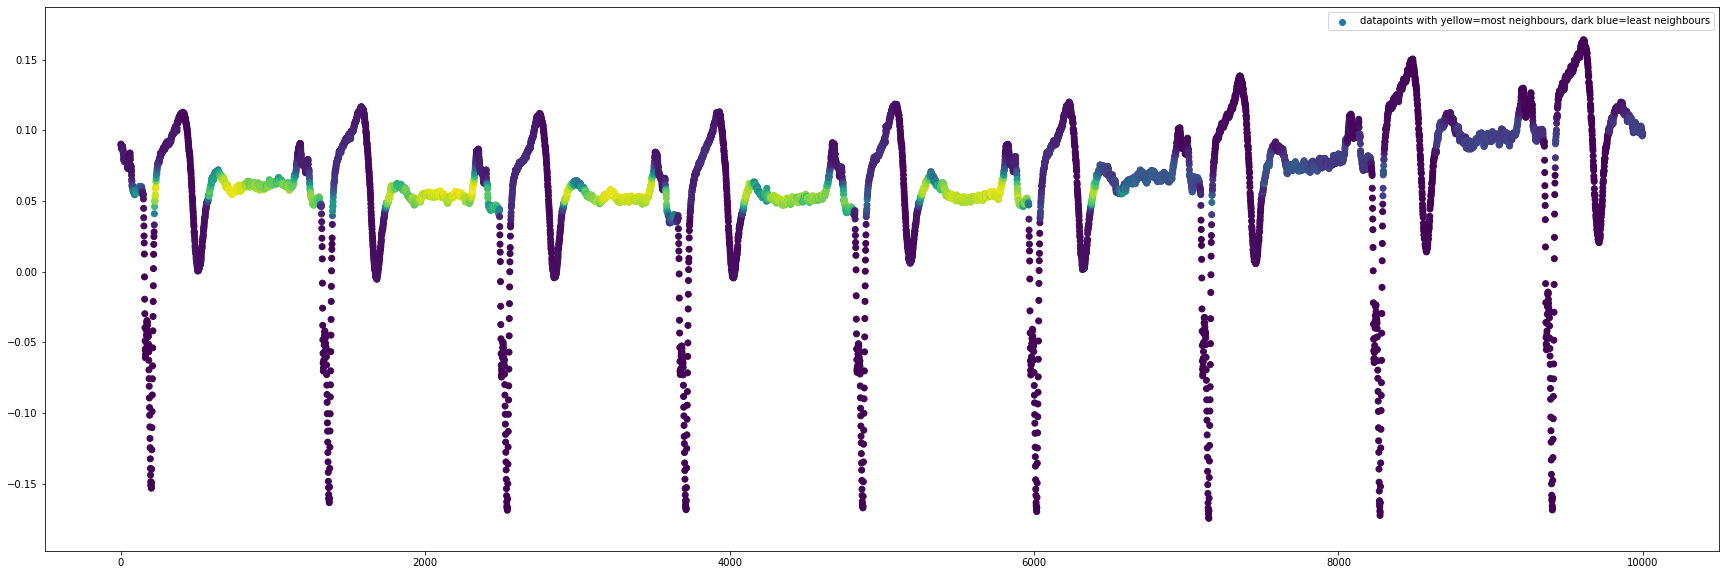

In [58]:
plt.figure(figsize=(30, 10))
plt.scatter(np.arange(len(data)), np.mean(data, axis=1), c=neighbour_counts/max(neighbour_counts), label='datapoints with yellow=most neighbours, dark blue=least neighbours')
#plt.plot(neighbour_counts/max(neighbour_counts), label='neighbour counts (scaled down)')
plt.legend()
plt.show()

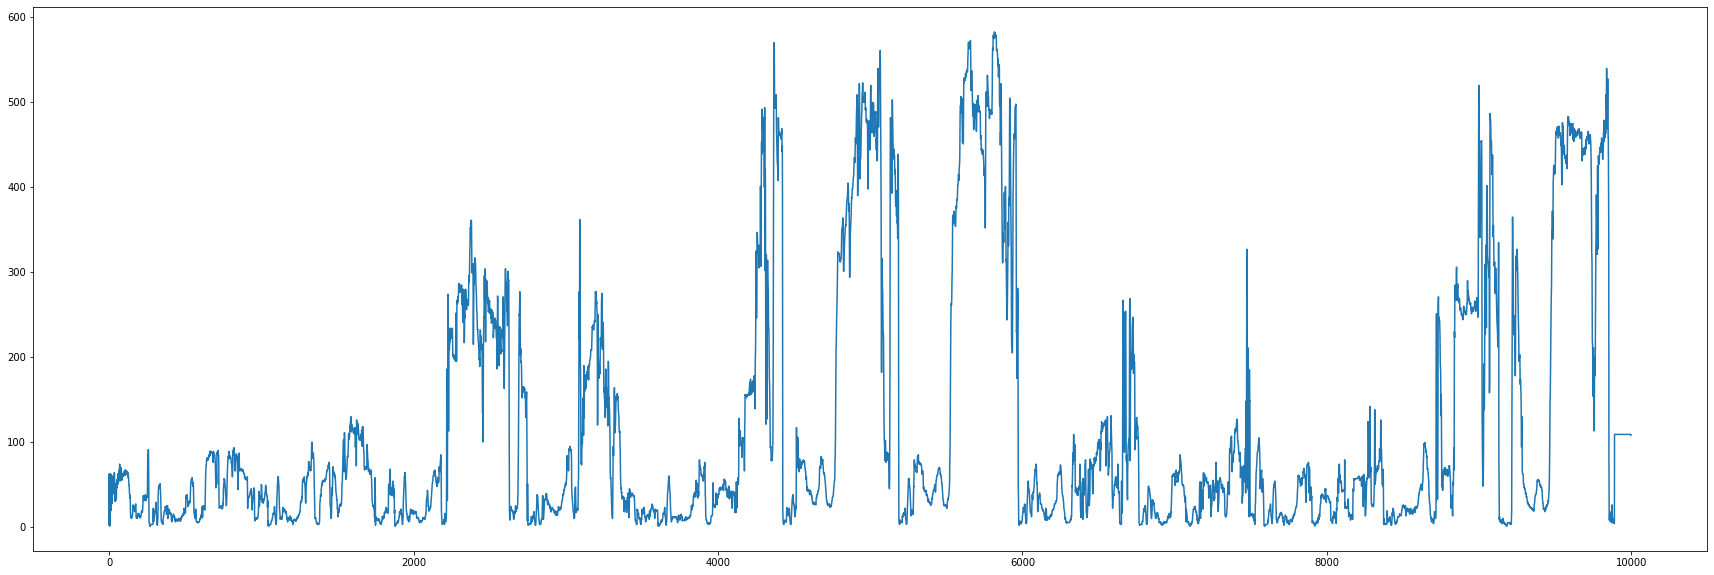

In [20]:
plt.figure(figsize=(30, 10))
plt.plot(np.sum(distm<=s, axis=1))

In [13]:
def _calc_and_plot(full_data, interval):
    data = full_data[interval]
    sums = np.sum(distm, axis=1)/len(distm)
    sums_inv = np.exp(-sums)
    m = np.mean(sums)
    s = np.std(sums)
    print('mean', m, 'standard deviation', s)
    devs = []
    for i in range(1, 100):
        devs += [np.argwhere((np.abs(sums-m) >= (i-1)*s) & (np.abs(sums-m)<i*s))]
        if len(devs[-1]) == 0:
            devs.pop()
            break
    print('elements in bins:', *map(len, devs))    
    plt.figure(figsize=(30, 10))
    plt.title("Outlier detection" + str(interval))
    for i,d in enumerate(devs):
        plt.scatter(np.arange(len(sums))[d], data[d, 1], label=str(i+1)+' std away from mean')
    plt.plot(sums_inv, label='inverted sums')
    plt.legend()
    plt.show()

In [47]:
def calc_and_plot(full_data):
    base_size = 10000
    n_windows = (len(full_data)-3)/base_size
    window_size = int(base_size*(n_windows-int(n_windows)))
    for i in range(int(n_windows)):
        _calc_and_plot(full_data, slice(i*window_size, (i+1)*window_size))

mean 0.05678442071515263 standard deviation 0.05377763711357506
elements in bins: 9347 251 140 69 46 44 66 37


IndexError: index 5197 is out of bounds for axis 0 with size 5197

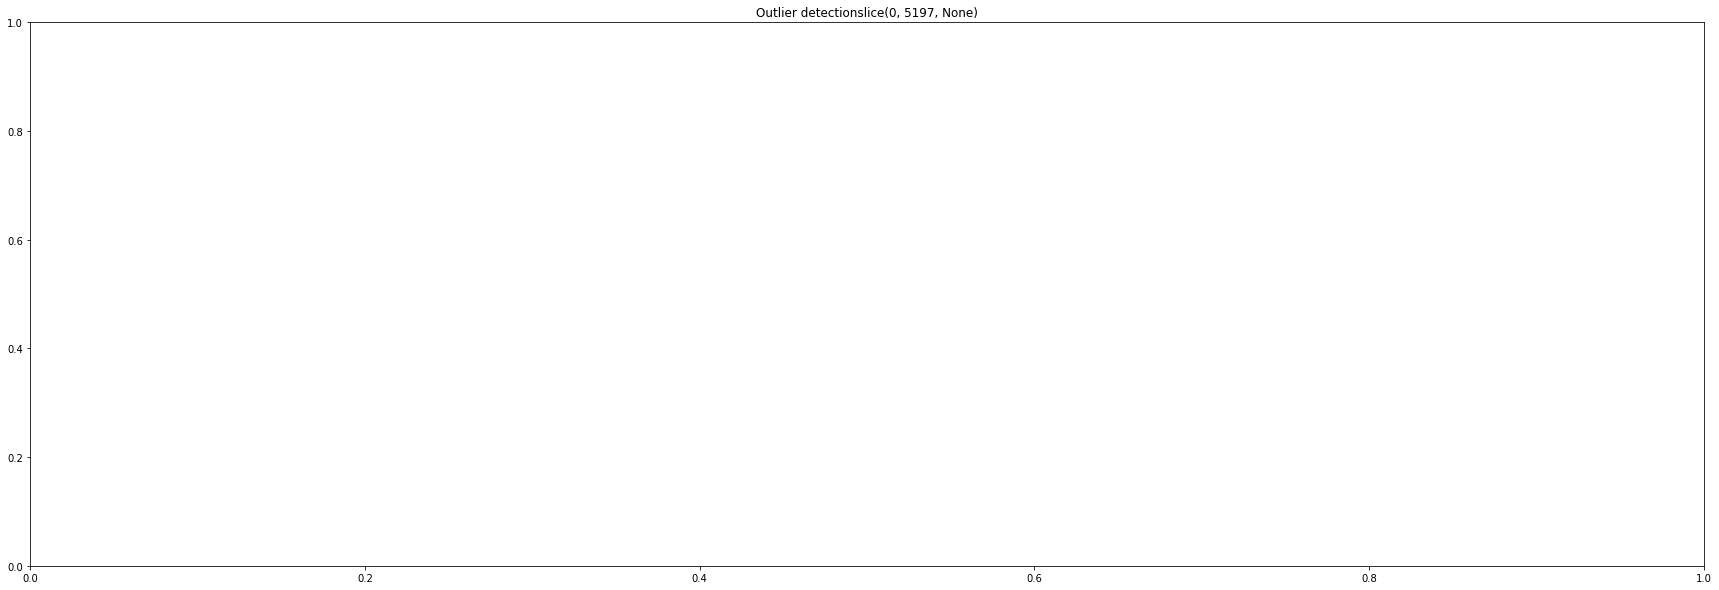

In [48]:
calc_and_plot(full_data)

In [14]:
def outlier_detection_nearest_epsilon(sorted_cols, k):
    l = []
    for col in sorted_cols:
        nei = col[0:k]
        kappa = nei[-1]
        min_dist = nei[0]
        gamma = np.mean(nei)
        var = np.var(nei)
        l.append([kappa, min_dist, gamma, var])
    return map(np.array, zip(*l))

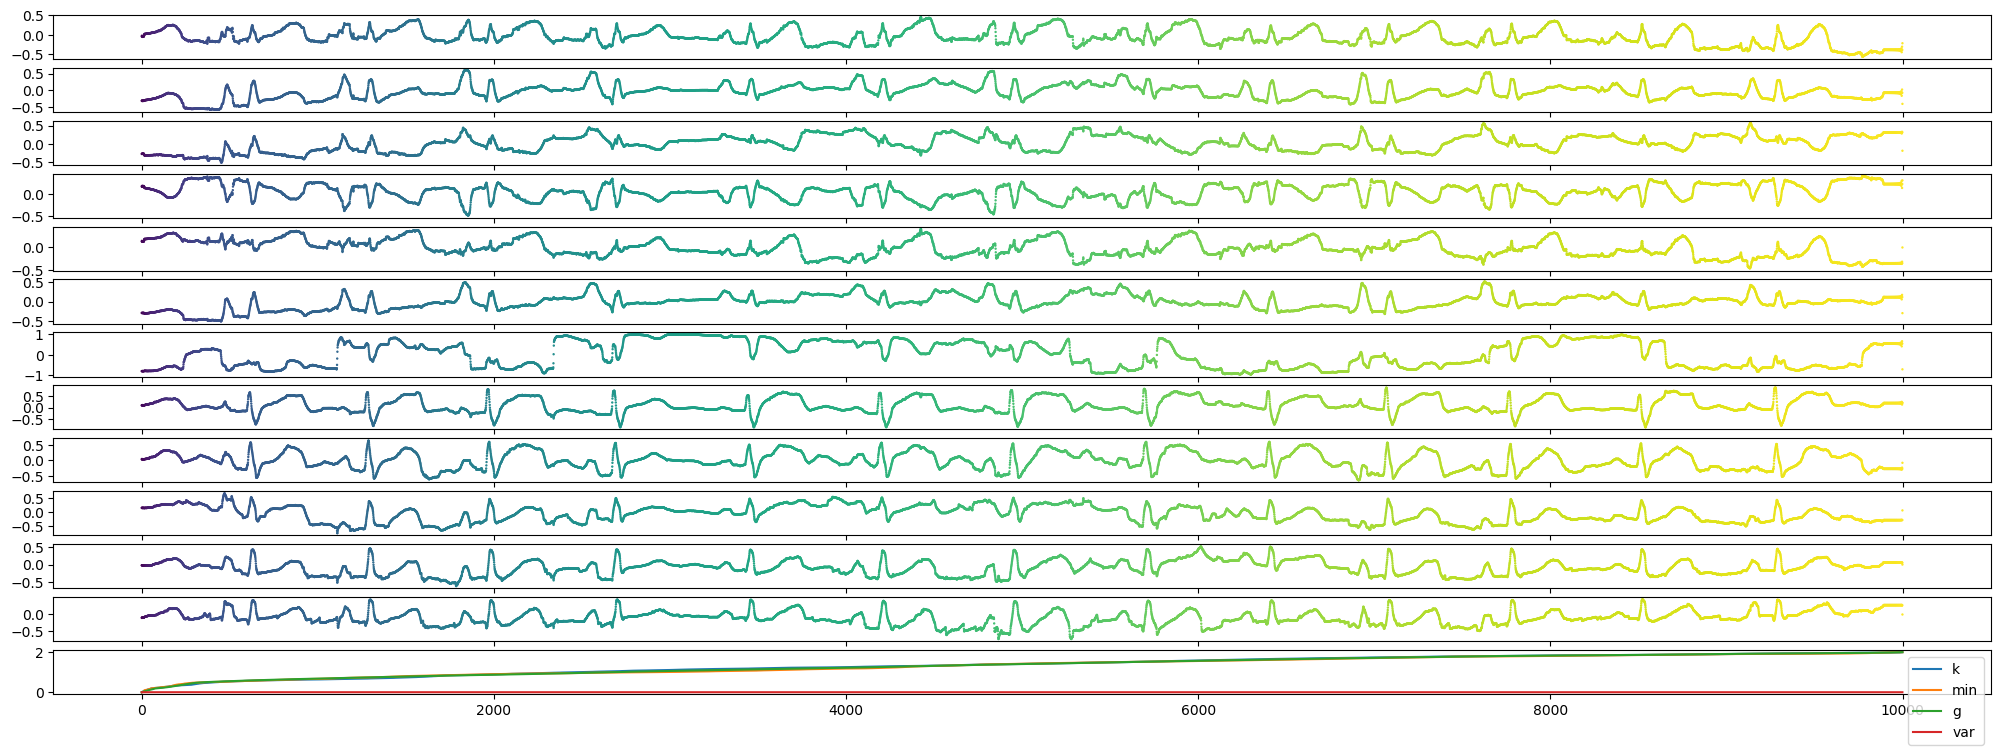

In [84]:
plot_metrics(data, *outlier_detection_nearest_epsilon(np.sort(distm, axis=0), 100))

In [16]:
kappas, min_dists, gammas, var = map(np.array, outlier_detection_nearest_epsilon(distm, 10000))

In [18]:
plot_metrics(data, kappas, min_dists, gammas, var, save='out/neighbors_'+str(10000)+'.png')

In [15]:
def plot_metrics(data, kappas, mins, gammas, var, save=None):
    x = np.arange(len(data))
    fig, axs = plt.subplots(data.shape[1]+1, 1, figsize=(len(data)/4/100, data.shape[1]*300/4/100), dpi=100, sharex=True)
    for i in range(len(axs)-1):
        axs[i].scatter(x, data[:, i], c=kappas, s=0.5)
    axs[-1].plot(kappas, label='k')
    axs[-1].plot(min_dists, label='min')
    axs[-1].plot(gammas, label='g')
    axs[-1].plot(var, label='var')
    if save:
        plt.savefig(save, dpi=100)
    else:
        plt.legend()
        plt.show()
    plt.close()

In [88]:
sorted_cols = np.sort(distm, axis=1)
for i in range(1, len(distm)//2, 2):
    kappas, min_dists, gammas, var = outlier_detection_nearest_epsilon(sorted_cols, k=i)
    plot_metrics(data, kappas, min_dists, gammas, var, save='out/neighbors_'+str(i)+'.png')
    print('Completed {} of {}'.format(i, len(distm)//2), flush=True)

Completed 0.05 of 250
Completed 0.15 of 250
Completed 0.25 of 250
Completed 0.35 of 250
Completed 0.45 of 250
Completed 0.55 of 250
Completed 0.65 of 250
Completed 0.75 of 250
Completed 0.85 of 250
Completed 0.95 of 250
Completed 1.05 of 250
Completed 1.15 of 250
Completed 1.25 of 250
Completed 1.35 of 250
Completed 1.45 of 250
Completed 1.55 of 250
Completed 1.65 of 250
Completed 1.75 of 250
Completed 1.85 of 250
Completed 1.95 of 250
Completed 2.05 of 250
Completed 2.15 of 250
Completed 2.25 of 250
Completed 2.35 of 250
Completed 2.45 of 250
Completed 2.55 of 250
Completed 2.65 of 250
Completed 2.75 of 250
Completed 2.85 of 250
Completed 2.95 of 250
Completed 3.05 of 250
Completed 3.15 of 250
Completed 3.25 of 250
Completed 3.35 of 250
Completed 3.45 of 250
Completed 3.55 of 250
Completed 3.65 of 250
Completed 3.75 of 250
Completed 3.85 of 250
Completed 3.95 of 250
Completed 4.05 of 250
Completed 4.15 of 250
Completed 4.25 of 250
Completed 4.35 of 250
Completed 4.45 of 250
Completed 

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000017CA413DA68> (for post_execute):


KeyboardInterrupt: 